# Project UAV

Version 1.0


In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from scipy.spatial import distance_matrix
from IPython.display import display, clear_output

#### initial parameters


In [12]:
NUM_GU = 10  # number of ground users

X_MIN = 0  # minimum x-axis [meter]
X_MAX = 100  # maximum x-axis [meter]
Y_MIN = 0  # minimum y-axis [meter]
Y_MAX = 100  # maximum y-axis [mseter]

UAV_ALTITUDE = 10  # altitude of uav [meter]
MAX_BEAM_ANGLE = 60  # maximum beamforming angle [degree]

# maximum beamforming diameter [meter]
MAX_BEAM_DIAMETER = 2 * UAV_ALTITUDE * np.tan(MAX_BEAM_ANGLE * np.pi / 180)

X_GRID = 10  # number of x grid
Y_GRID = 10  # number of y grid


UAV_TX_POWER = 30  # uav's transmit power in [dBm]


#### initial variables


In [13]:
t = 0  # time [seconds]

gu_bat = np.zeros((NUM_GU,))  # battery of ground user [mWh]


#### generate variables


In [14]:
# generate ground user location randomly x,y,z [meters]
gu_x = np.random.uniform(low=X_MIN, high=X_MAX, size=(NUM_GU,))
gu_y = np.random.uniform(low=Y_MIN, high=Y_MAX, size=(NUM_GU,))
gu_z = np.zeros((NUM_GU,))

# print
gu_x, gu_y, gu_z


(array([49.37580718, 27.18914542, 12.34662168, 16.98527874, 98.65032365,
        51.06676129,  7.88158154, 94.55960802, 79.99876239, 93.75179977]),
 array([28.20212337, 61.2078193 , 89.25412382, 84.31359049, 88.20823497,
        97.16805034, 75.40046501, 60.68251003, 21.27802265, 61.91527183]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [15]:
# generate meshgrid
tmp_x = np.linspace(X_MIN + X_GRID / 2, X_MAX - X_GRID / 2, X_GRID)
tmp_y = np.linspace(Y_MIN + Y_GRID / 2, Y_MAX - Y_GRID / 2, Y_GRID)
GRID = np.array(np.meshgrid(tmp_x, tmp_y))

GRID

array([[[ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.],
        [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.]],

       [[ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.],
        [15., 15., 15., 15., 15., 15., 15., 15., 15., 15.],
        [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
        [35., 35., 35., 35., 35., 35., 35., 35., 35., 35.],
        [45., 45., 45., 45., 45., 45., 45., 45., 45., 45.],
        [55., 55., 55., 55., 55., 55., 55., 55., 55., 55.],
        [65., 65., 65., 65., 65., 65.,

In [16]:
# generate uav location
# x position of uav 0,1,...,GRID_SIZE-1
uav_x_pos = np.random.randint(0, X_GRID)
# y position of uav 0,1,...,GRID_SIZE-1
uav_y_pos = np.random.randint(0, Y_GRID)

uav_x = GRID[0, uav_x_pos, uav_y_pos]
uav_y = GRID[1, uav_x_pos, uav_y_pos]
uav_z = UAV_ALTITUDE  # uav's altitude [meter]


# print
uav_x, uav_y, uav_z


(15.0, 25.0, 10)

#### plot environment


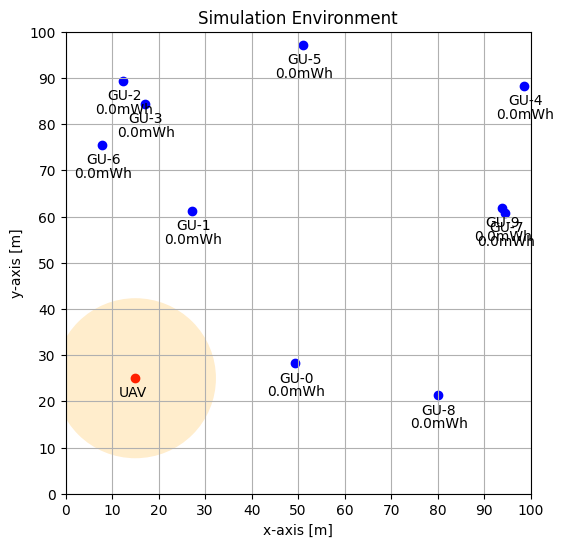

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))


plt.scatter(x=uav_x, y=uav_y, c="red")
plt.text(x=uav_x - 3.5, y=uav_y - 4, s=f"UAV")
beam_circle = Ellipse(
    xy=(uav_x, uav_y),
    width=MAX_BEAM_DIAMETER,
    height=MAX_BEAM_DIAMETER,
    angle=0,
    edgecolor="none",
    facecolor="orange",
    alpha=0.2,
)
uav_beam = ax.add_patch(beam_circle)


for i in range(NUM_GU):
    plt.scatter(x=gu_x[i], y=gu_y[i], c="blue")
    plt.text(x=gu_x[i] - 3.5, y=gu_y[i] - 4, s=f"GU-{i}")
    plt.text(x=gu_x[i] - 6, y=gu_y[i] - 7, s=f"{gu_bat[i]}mWh")


plt.xlabel("x-axis [m]")
plt.ylabel("y-axis [m]")
plt.title("Simulation Environment")
plt.xticks(np.arange(X_MIN, X_MAX + 1, X_GRID))
plt.yticks(np.arange(Y_MIN, Y_MAX + 1, Y_GRID))
plt.xlim(X_MIN, X_MAX)
plt.ylim(Y_MIN, Y_MAX)
plt.grid()
plt.show()

#### uav moves example


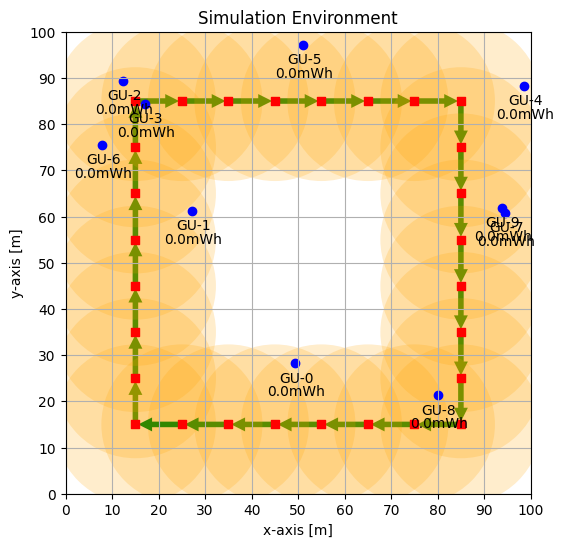

In [46]:
uav_x_pos, uav_y_pos = np.array([
    [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8],
    [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8],
    [8, 7], [8, 6], [8, 5], [8, 4], [8, 3], [8, 2], [8, 1],
    [7, 1], [6, 1], [5, 1], [4, 1], [3, 1], [2, 1], [1, 1],
]).T

uav_y, uav_x = GRID[:, uav_x_pos, uav_y_pos]

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_xlabel("x-axis [m]")
ax.set_ylabel("y-axis [m]")
ax.set_title("Simulation Environment")
ax.set_xticks(np.arange(X_MIN, X_MAX + 1, X_GRID))
ax.set_yticks(np.arange(Y_MIN, Y_MAX + 1, Y_GRID))
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.grid()


for i in range(NUM_GU):
    ax.scatter(x=gu_x[i], y=gu_y[i], c="blue")
    ax.text(x=gu_x[i] - 3.5, y=gu_y[i] - 4, s=f"GU-{i}")
    ax.text(x=gu_x[i] - 6, y=gu_y[i] - 7, s=f"{gu_bat[i]}mWh")


# ax.scatter(x=uav_x[0], y=uav_y[0], c="red")
# ax.text(x=uav_x[0] - 3.5, y=uav_y[0] - 4, s=f"UAV")
# beam_circle = Ellipse(
#     xy=(uav_x[0], uav_y[0]),
#     width=MAX_BEAM_DIAMETER,
#     height=MAX_BEAM_DIAMETER,
#     angle=0,
#     edgecolor="none",
#     facecolor="orange",
#     alpha=0.2,
# )
# uav_beam = ax.add_patch(beam_circle)

for i in range(len(uav_x) - 1):
    arrow = mpatches.FancyArrowPatch(
        (uav_x[i], uav_y[i]),
        (uav_x[i + 1], uav_y[i + 1]),
        edgecolor="none",
        facecolor="green",
        mutation_scale=20,
        zorder=0
    )
    tmp = ax.add_patch(arrow)

    scatter_uav = ax.scatter(
        x=uav_x[i], y=uav_y[i], c="red", marker="s", zorder=1)
    beam_circle = Ellipse(
        xy=(uav_x[i], uav_y[i]),
        width=MAX_BEAM_DIAMETER,
        height=MAX_BEAM_DIAMETER,
        angle=0,
        edgecolor="none",
        facecolor="orange",
        alpha=0.2,
        zorder=0,
    )
    # if i > 0:
    #     ax.remove(uav_beam[i])
    uav_beam = ax.add_patch(beam_circle)

    display(fig)
    clear_output(wait=True)
    time.sleep(0.1)
